In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/datasets/global-temp/master/data/monthly.csv')
df.head()

,Source,Date,Mean
0,GCAG,2016-12,0.7895
1,GISTEMP,2016-12,0.8100
2,GCAG,2016-11,0.7504
3,GISTEMP,2016-11,0.9300
4,GCAG,2016-10,0.7292


<Axes: >

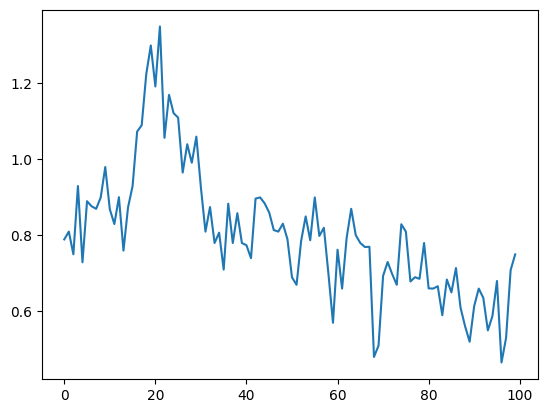

In [4]:
### basic time series plot - 
df.Mean[:100].plot()

<Axes: >

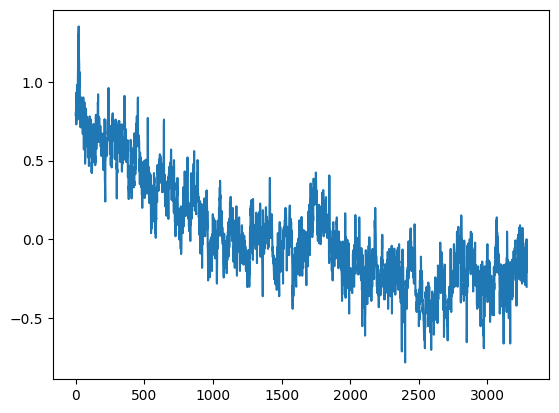

In [5]:
df.Mean.plot()

### In this plot here we dont really have data types that are actually helpfull,
### the graph is hard to visualize and it really is not giving us much information, 
### so lets change that!

In [6]:
df = df.pivot(index='Date', columns='Source', values='Mean')

### Now that weve rearanged our data were looking at one time series instead of two,
### if we have two time series in our data we should not be looking to plot that as it
### would be messy and unclear

<Axes: xlabel='Date'>

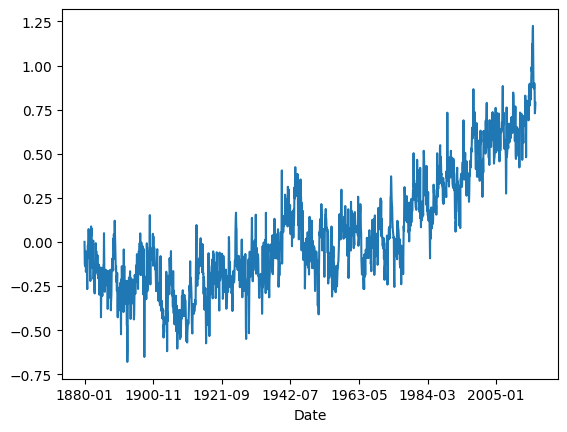

In [7]:
df.GCAG.plot()

### Now lets modify our indexes to make them more 'time aware'

In [8]:
from datetime import datetime

In [9]:
df.index = pd.to_datetime(df.index)

In [10]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

<Axes: xlabel='Date'>

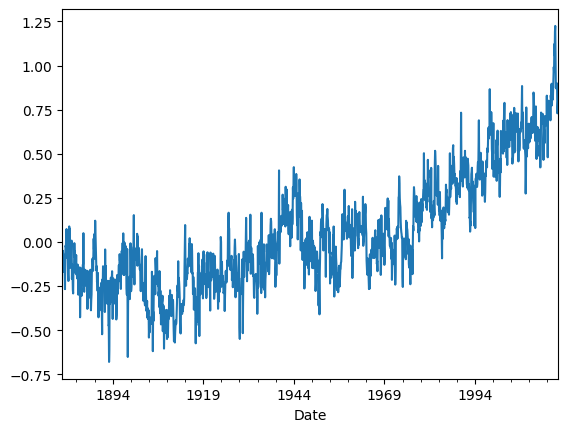

In [11]:
df.GCAG.plot()

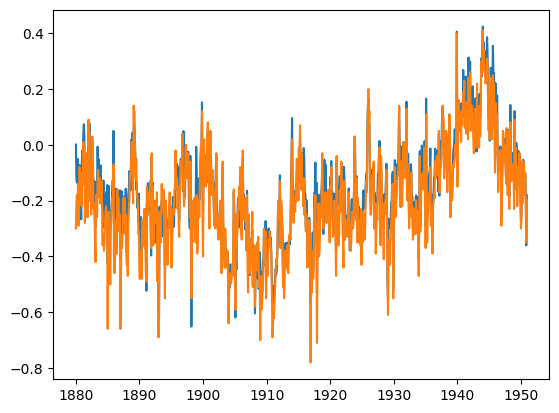

In [12]:
plt.plot(df['1880':'1950'][['GCAG', 'GISTEMP']])

#### How strongly do these measurements correlate at the same time? What about the time lag?

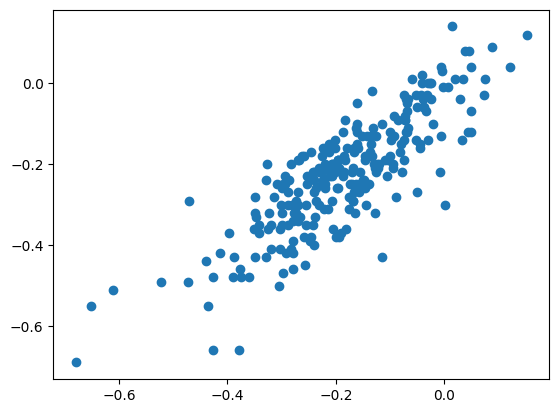

In [13]:
### Plotting two measeruments - GCAG and GISTEMP against the same time periods
### and as we can see they correlate pretty strongly 
plt.scatter(df['1880':'1900'][['GCAG']], df['1880':'1900'][['GISTEMP']])

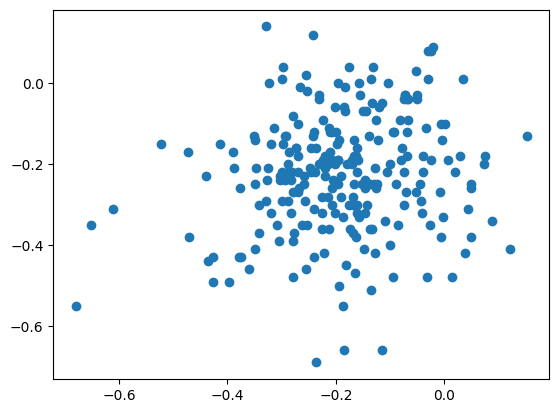

In [14]:
plt.scatter(df['1880':'1899'][['GCAG']], df['1881':'1900'][['GISTEMP']])

In [15]:
from scipy.stats import pearsonr

In [16]:
pearsonr(df['1880':'1899'].GCAG, df['1881':'1900'].GISTEMP)

PearsonRResult(statistic=0.1546405732961276, pvalue=0.01650223473095094)

In [17]:
df['1880':'1899'][['GCAG']].head()

Source,GCAG
Date,
1880-01-01,0.0009
1880-02-01,-0.1229
1880-03-01,-0.1357
1880-04-01,-0.0499
1880-05-01,-0.0738


In [18]:
df['1881':'1900'][['GISTEMP']].head()

Source,GISTEMP
Date,
1881-01-01,-0.10
1881-02-01,-0.14
1881-03-01,0.01
1881-04-01,-0.03
1881-05-01,-0.04


In [19]:
min(df.index)

Timestamp('1880-01-01 00:00:00')

In [20]:
max(df.index)

Timestamp('2016-12-01 00:00:00')

### Unobserved component model

In [21]:
train = df['1960':]

In [22]:
### smooth trend model w/o seasonal or cyclical components - hyper param turning here :3
model = {
    'level': 'smooth trend', 'cycle': False, 'seasonal': None,
}

In [23]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [24]:
import statsmodels.api as sm

In [25]:
gcag_mod = sm.tsa.UnobservedComponents(train['GCAG'], **model)
gcag_res = gcag_mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.66780D-02    |proj g|=  2.51380D+00

At iterate    5    f= -8.82781D-01    |proj g|=  5.00883D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     28      1     0     0   3.166D-04  -8.828D-01
  F = -0.88278465741802081     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


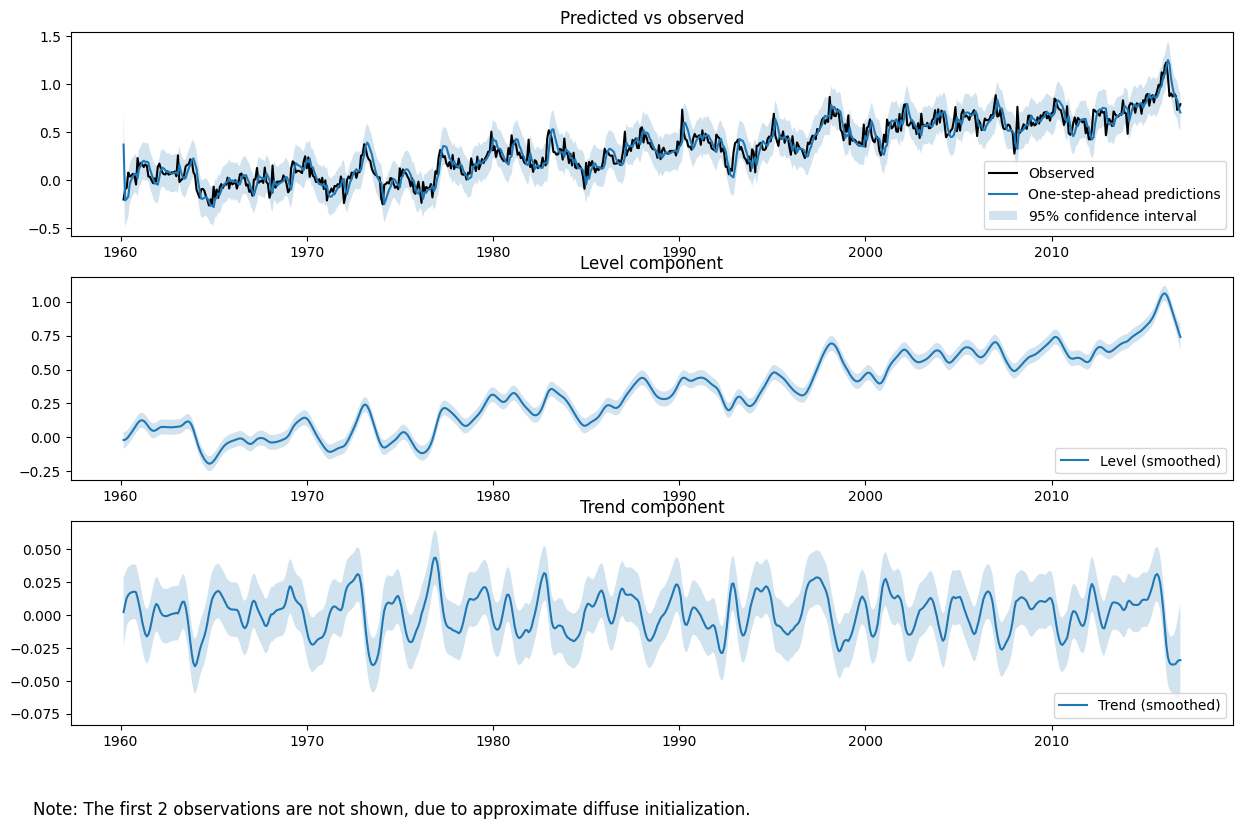

In [26]:
fig = gcag_res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [27]:
### within our ci , nut really we dont get much info when looking at our components

### Plotting Predictions

In [28]:
 # Perform rolling preds and multistep forecast
num_steps = 20
predict_res = gcag_res.get_prediction(dynamic=train['GCAG'].shape[0] - num_steps) # last 20 steps
    # as dynamic

predict = predict_res.predicted_mean
ci = predict_res.conf_int()

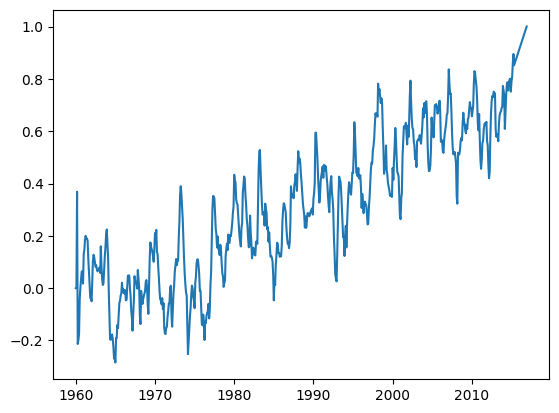

In [29]:
plt.plot(predict)

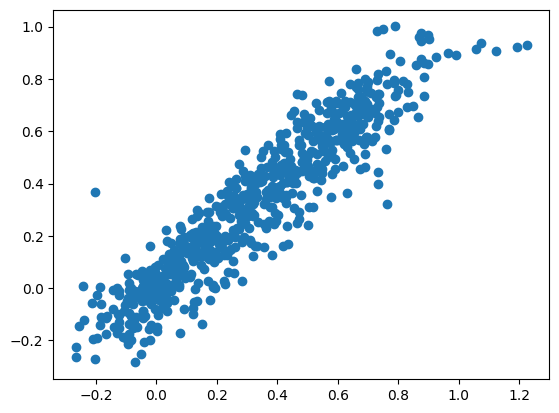

In [30]:
plt.scatter(train['GCAG'], predict)

### looks like the model did pretty well..

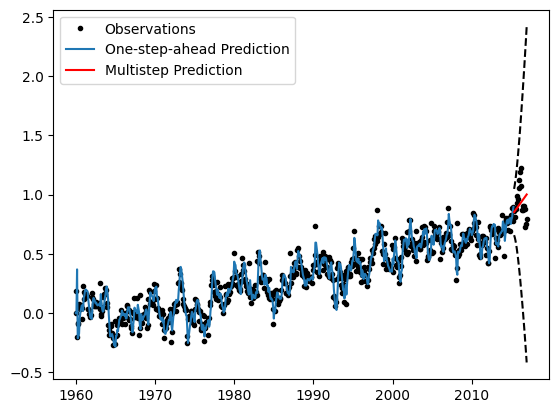

In [31]:
### if we want to do a cleaner plot with dynamic preds and confidence bounds

fig, ax = plt.subplots()

#ax.plot(train.index['GCAG'], 'k.', label='Observations');
ax.plot(train['GCAG'].index, train['GCAG'], 'k.', label='Observations');

ax.plot(train.index[:-num_steps:], predict[:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

### cleaning up the img
legend = ax.legend(loc='upper left');

## dotted lines show the confidence bounds
## red lines show the dynamic predictions

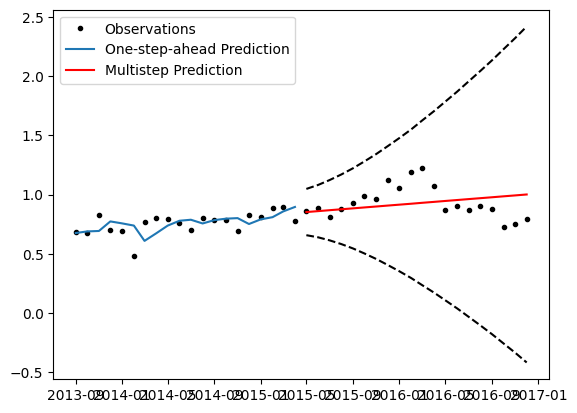

In [32]:

### same just zooming in 
fig, ax = plt.subplots()

#ax.plot(train.index['GCAG'], 'k.', label='Observations');
ax.plot(train.index[-40:], train['GCAG'][-40:], 'k.', label='Observations');

ax.plot(train.index[-40:-num_steps], predict[-40:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

### cleaning up the img
legend = ax.legend(loc='upper left');

#### forward moving pred turns flat

### Now consider adding a seasonal term for 12 periods for the model fit above, 
### does this improve the fit of the model?

In [33]:
### adding seasonal term

seasonal_model = {
    'level': 'local linear trend',
    'seasonal': 12 # 12 bc its monthly data were working with
}
mod = sm.tsa.UnobservedComponents(train['GCAG'], **seasonal_model)
res = mod.fit(method='powell', disp=False)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


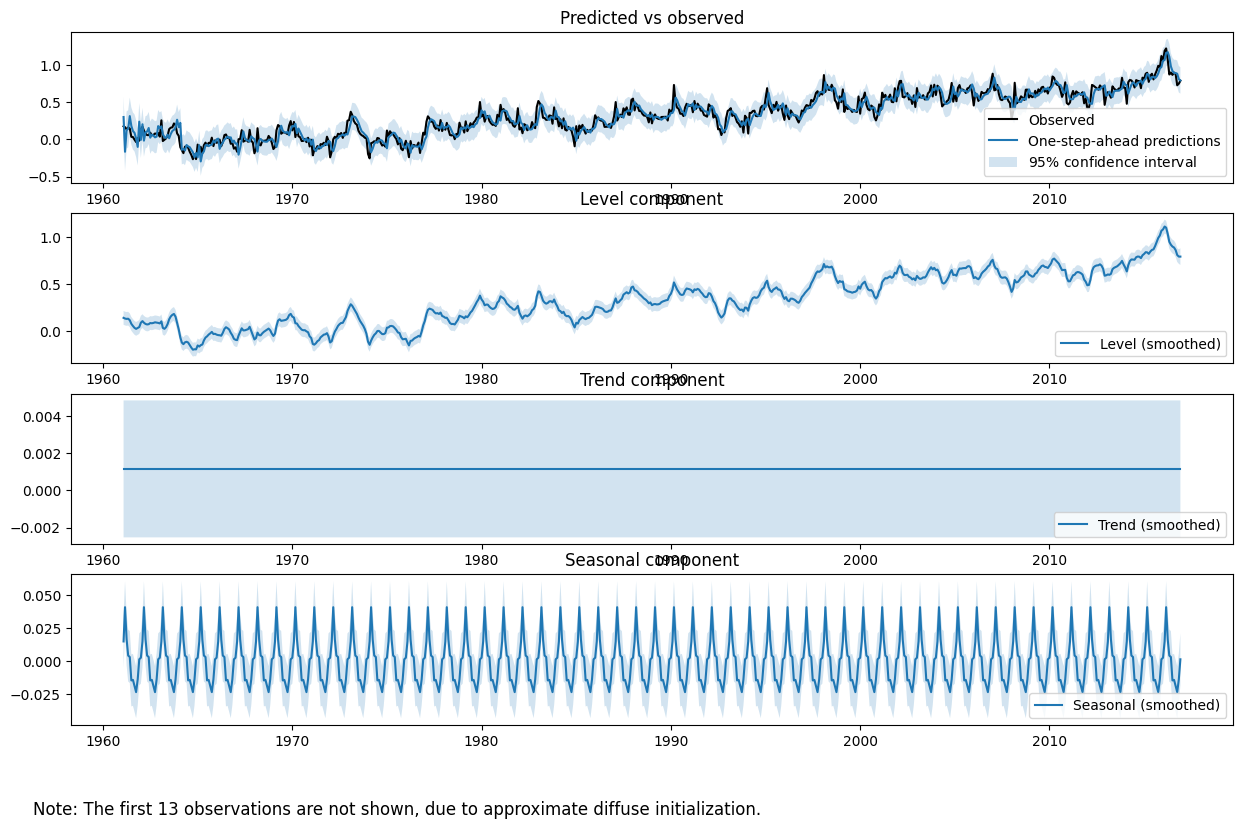

In [34]:
fig = res.plot_components(legend_loc='lower right', figsize=(15, 9));

#### We have a level component and a seasonal component - 
#### as someone not familiar with time series data these terms are not meaning anything 
#### to me :< but it looks like aimee will give a bit more intuition on this 
#### later in the talk!

### Lets look at how these models compare to the original model!

In [35]:
pearsonr(gcag_res.predict(), train['GCAG'])

PearsonRResult(statistic=0.9376554612284693, pvalue=3.16463779e-315)

In [36]:
pearsonr(res.predict(), train['GCAG'])

PearsonRResult(statistic=0.9443196892484267, pvalue=0.0)

### There is not a significant difference in the values, but visuallt we 
### do see a lot more in the second model.. so smt to consider

In [37]:
### looking at the mean absolute error in our model 
np.mean(np.abs(gcag_res.predict() - train['GCAG']))

0.07721215662191556

## Explore seasonality more

In [38]:
### prunning components that werent specially usefull
seasonal_model = {
    'level': 'local level',
    'seasonal': 12
}
llmod = sm.tsa.UnobservedComponents(train['GCAG'], **seasonal_model)
ll_level_res = llmod.fit(method='powell', disp=False)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


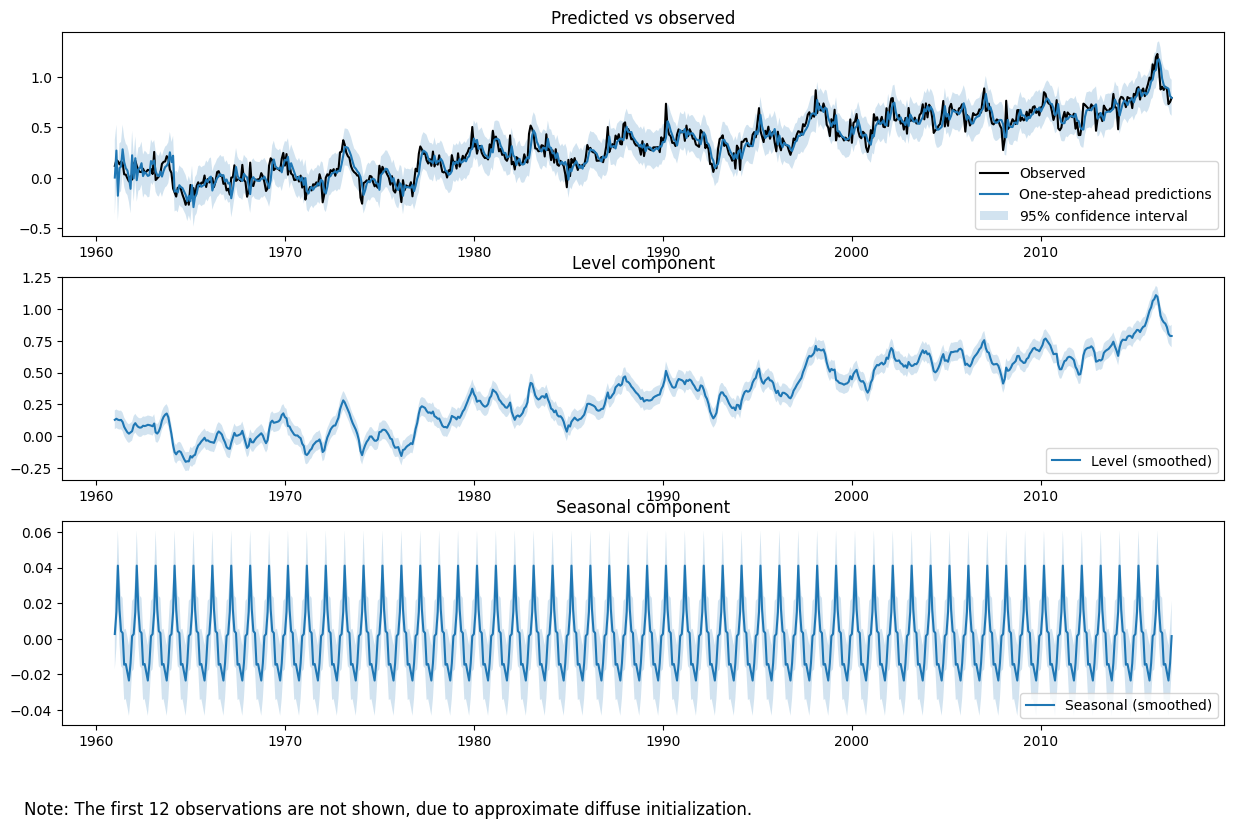

In [39]:
fig = ll_level_res.plot_components(legend_loc='lower right', figsize=(15, 9));

### so now we see the seasonality even more clearly and the overall trend being positive

In [40]:
np.mean(np.abs(ll_level_res.predict() - train['GCAG']))

0.07157760213054734

##### slow improvements

<Axes: xlabel='Date'>

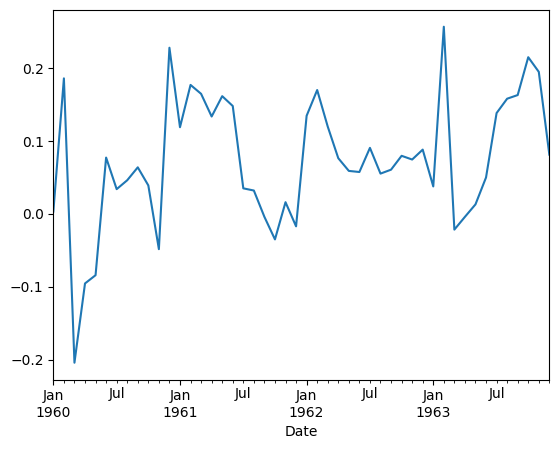

In [41]:
train[:48].GCAG.plot()

#### Ex. a common null model for time series is to predict the value at time t-1 for the value at time t . How does such a model compare to the models we fit here?

### Traditional ML models on Timeseries 📉📉

In [42]:
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [10, 10]

In [43]:
import cesium 
import xgboost as xgb 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import time 

from cesium import datasets
from cesium import featurize as ft 

import scipy 
from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew

import sklearn 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [44]:
!pip install cesium

In [45]:
### Loading our dataset and generating some features of interest
eeg = datasets.fetch_andrzejak()

In [46]:
type(eeg)

dict

In [47]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

In [48]:
### eeg - so were looking at brain data here

## Visually Inspect 

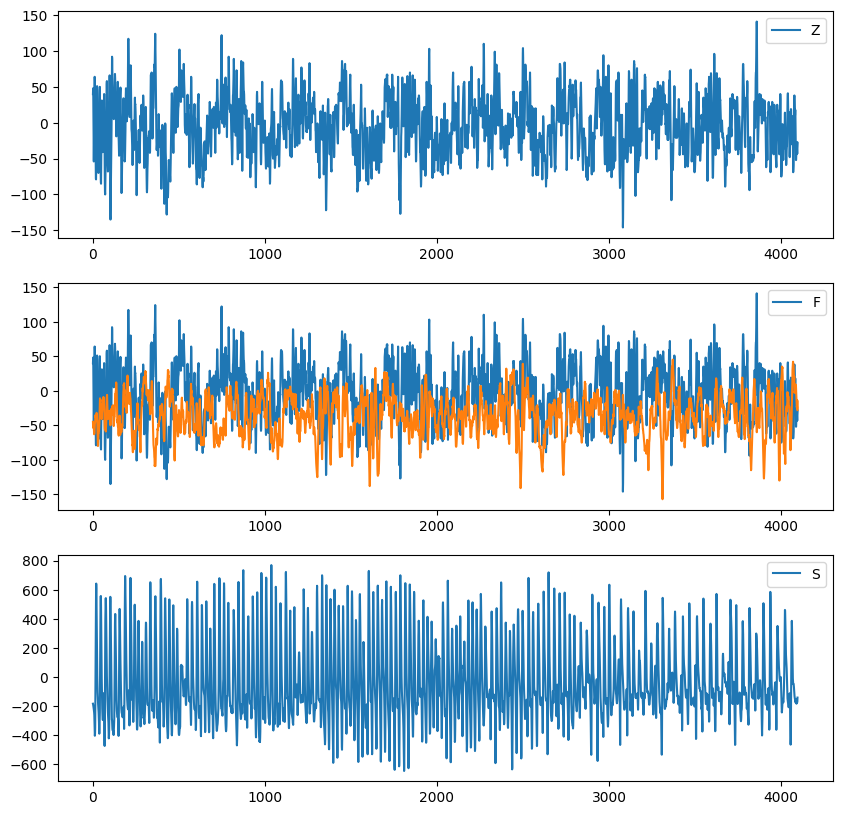

In [49]:
plt.subplot(3, 1, 1)
plt.plot(eeg['measurements'][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg['measurements'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg['measurements'][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg['measurements'][450])
plt.legend(eeg['classes'][450])

In [50]:
type(eeg['measurements'][0])

numpy.ndarray

In [51]:
type(eeg)

dict

In [52]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

In [53]:
len(eeg['measurements'])

500

In [54]:
eeg['measurements'][0].shape

(4097,)

## Performing Feature Selection

In [55]:
from cesium import featurize as ft 
features_to_use = ['amplitude',
                   'percent_beyond_1_std',
                   'percent_close_to_median',
                   'skew',
                   'max_slope']

fset_cesium = ft.featurize_time_series(times=eeg['times'],
                                      values=eeg['measurements'],
                                      errors=None,
                                      features_to_use=features_to_use,
                                      scheduler=None)

In [56]:
fset_cesium.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153


#### Handcoding features ourselves

In [57]:
ex = eeg['measurements'][0]

In [58]:
ex_mean = np.mean(ex)
ex_std = np.std(ex)

In [59]:
(np.max(ex) - np.min(ex)) / 2

143.5

In [60]:
## amplitude 

(np.max(ex) - np.min(ex)) / 2

143.5

In [61]:
siz = len(ex)
ll = ex_mean - ex_std 
ul = ex_mean + ex_std 

In [62]:
quals = [i for i in range(siz) if ex[i] < ll or ex[i] > ul]
len(quals)/len(ex)

0.3273126678057115

In [63]:
window = 0.1 * (np.max(ex) - np.min(ex))
np.where(np.abs(ex_mean - ex) < window)[0].shape[0] / ex.shape[0]

0.5050036612155235

0.03280499636078603


(array([  10.,   57.,  276.,  730., 1048., 1042.,  621.,  263.,   42.,
           8.]),
 array([-146. , -117.3,  -88.6,  -59.9,  -31.2,   -2.5,   26.2,   54.9,
          83.6,  112.3,  141. ]),
 <BarContainer object of 10 artists>)

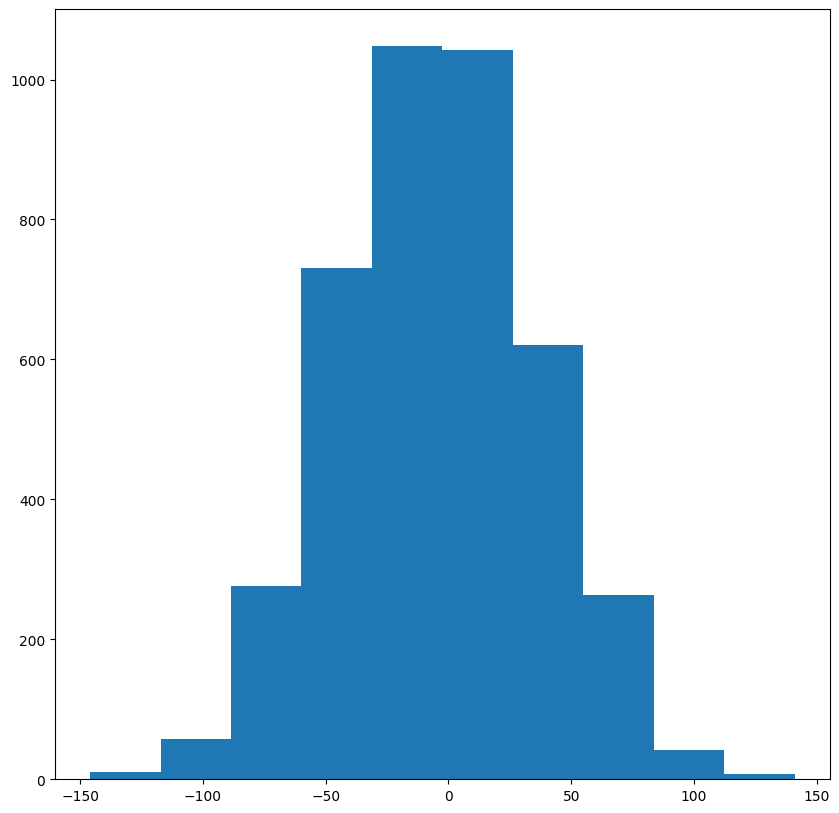

In [64]:
### skew 
print(skew(ex))
plt.hist(ex)

In [65]:
### max slope 
### check cesium dcmt for def
times = eeg['times'][0]
np.max(np.abs(np.diff(ex)/np.diff(times)))

11107.796610166752

(array([  2.,   3.,   1.,   9.,  12.,  40., 163., 227.,  34.,   9.]),
 array([0.09738833, 0.12672687, 0.15606541, 0.18540395, 0.21474249,
        0.24408103, 0.27341958, 0.30275812, 0.33209666, 0.3614352 ,
        0.39077374]),
 <BarContainer object of 10 artists>)

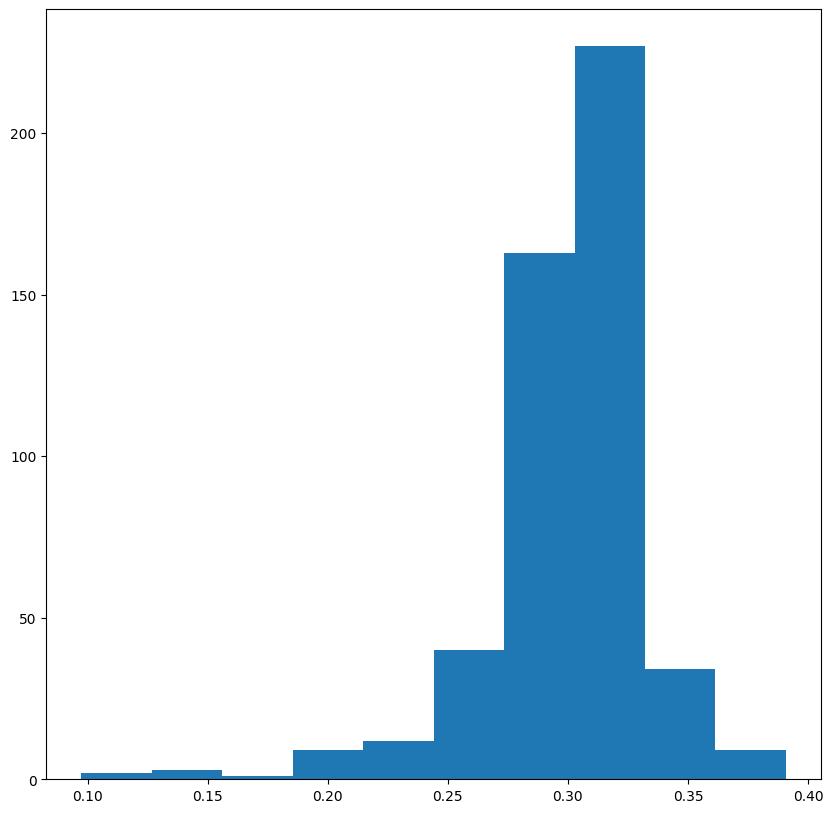

In [66]:
plt.hist(fset_cesium.iloc[:, 1])

In [67]:
fset_cesium['classes']= eeg['classes']

In [68]:
fset_cesium.columns = fset_cesium.columns.droplevel(-1)

classes
F    Axes(0.125,0.11;0.775x0.77)
N    Axes(0.125,0.11;0.775x0.77)
O    Axes(0.125,0.11;0.775x0.77)
S    Axes(0.125,0.11;0.775x0.77)
Z    Axes(0.125,0.11;0.775x0.77)
Name: amplitude, dtype: object

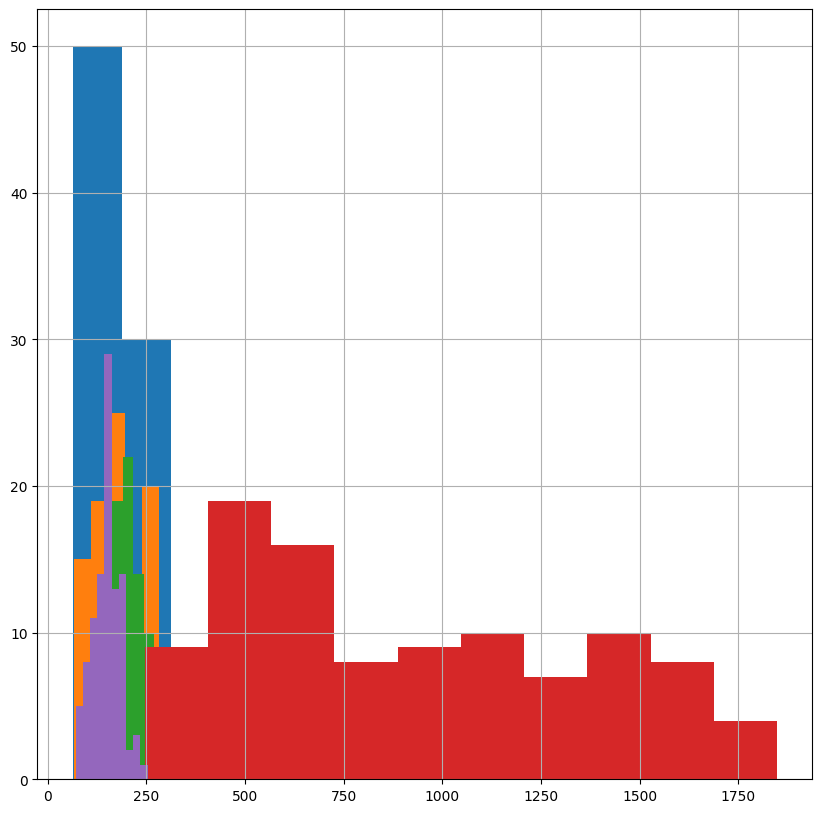

In [69]:
fset_cesium.groupby('classes')['amplitude'].hist()

array([[<Axes: title={'center': 'F'}>, <Axes: title={'center': 'N'}>],
       [<Axes: title={'center': 'O'}>, <Axes: title={'center': 'S'}>],
       [<Axes: title={'center': 'Z'}>, <Axes: >]], dtype=object)

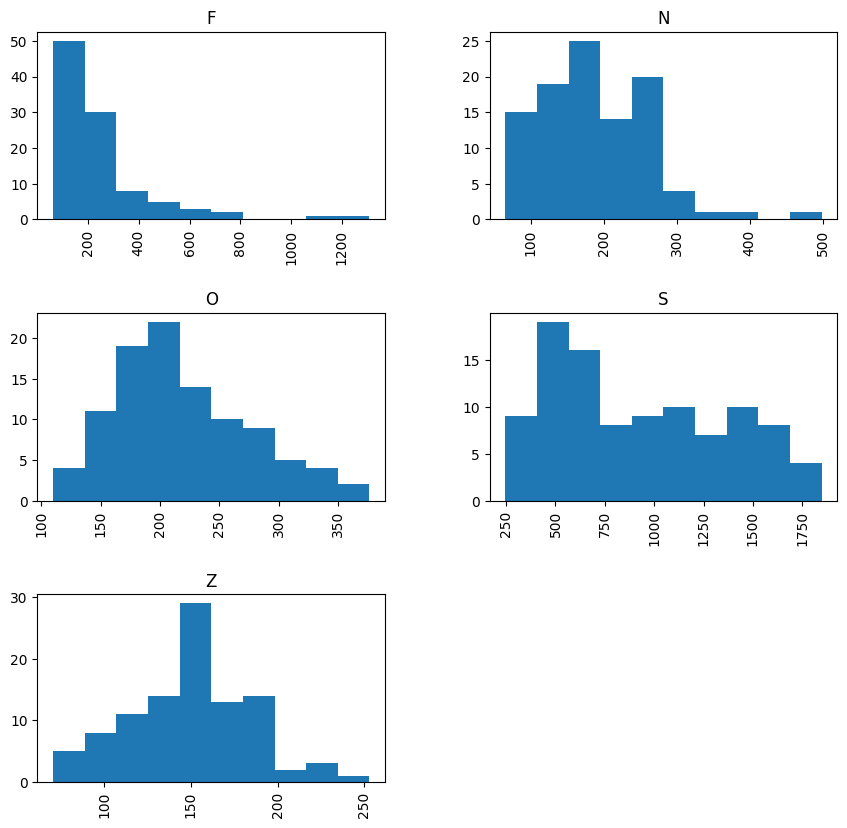

In [70]:
fset_cesium['amplitude'].hist(by=fset_cesium['classes'])

array([[<Axes: title={'center': 'F'}>, <Axes: title={'center': 'N'}>],
       [<Axes: title={'center': 'O'}>, <Axes: title={'center': 'S'}>],
       [<Axes: title={'center': 'Z'}>, <Axes: >]], dtype=object)

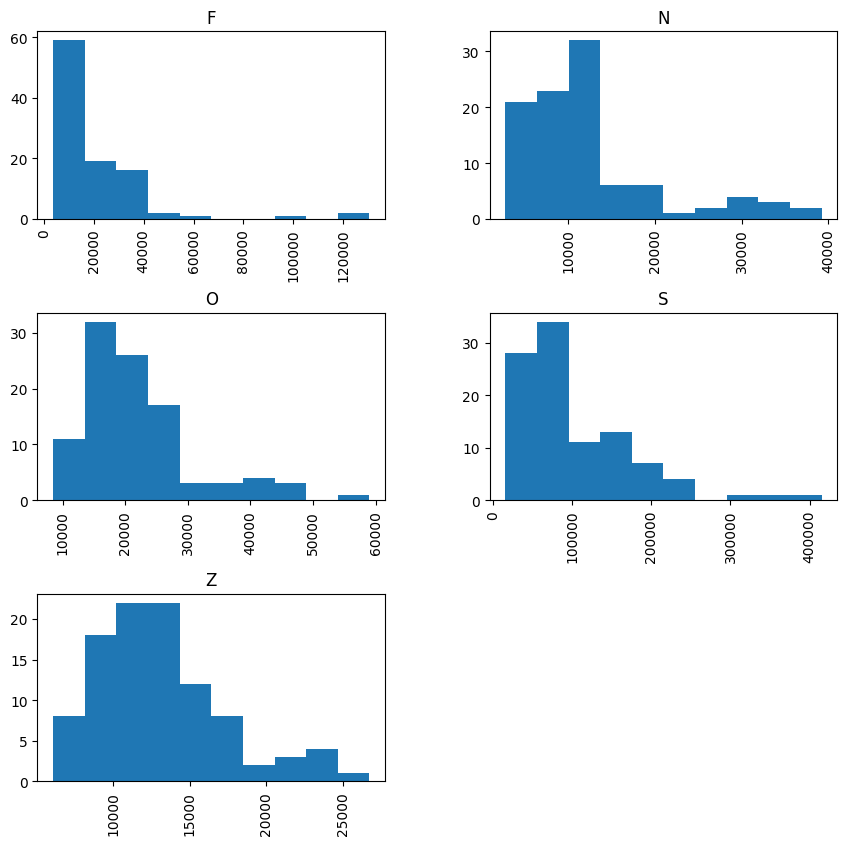

In [71]:
fset_cesium['max_slope'].hist(by=fset_cesium['classes'])

classes
F    Axes(0.125,0.11;0.775x0.77)
N    Axes(0.125,0.11;0.775x0.77)
O    Axes(0.125,0.11;0.775x0.77)
S    Axes(0.125,0.11;0.775x0.77)
Z    Axes(0.125,0.11;0.775x0.77)
Name: amplitude, dtype: object

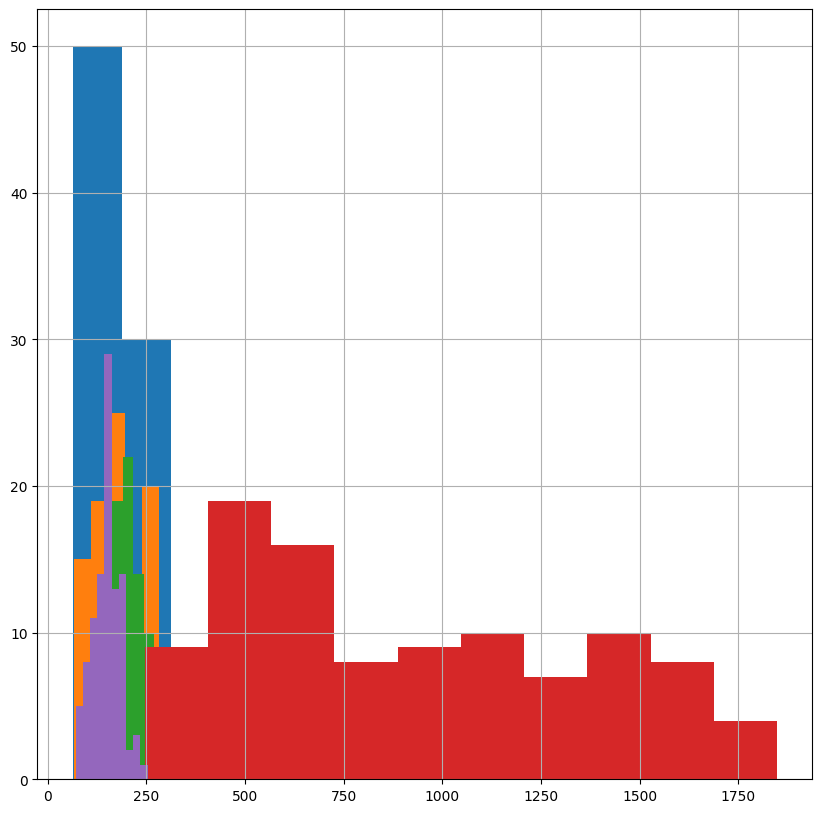

In [72]:
fset_cesium.groupby('classes')['amplitude'].hist()

array([[<Axes: title={'center': 'F'}>, <Axes: title={'center': 'N'}>],
       [<Axes: title={'center': 'O'}>, <Axes: title={'center': 'S'}>],
       [<Axes: title={'center': 'Z'}>, <Axes: >]], dtype=object)

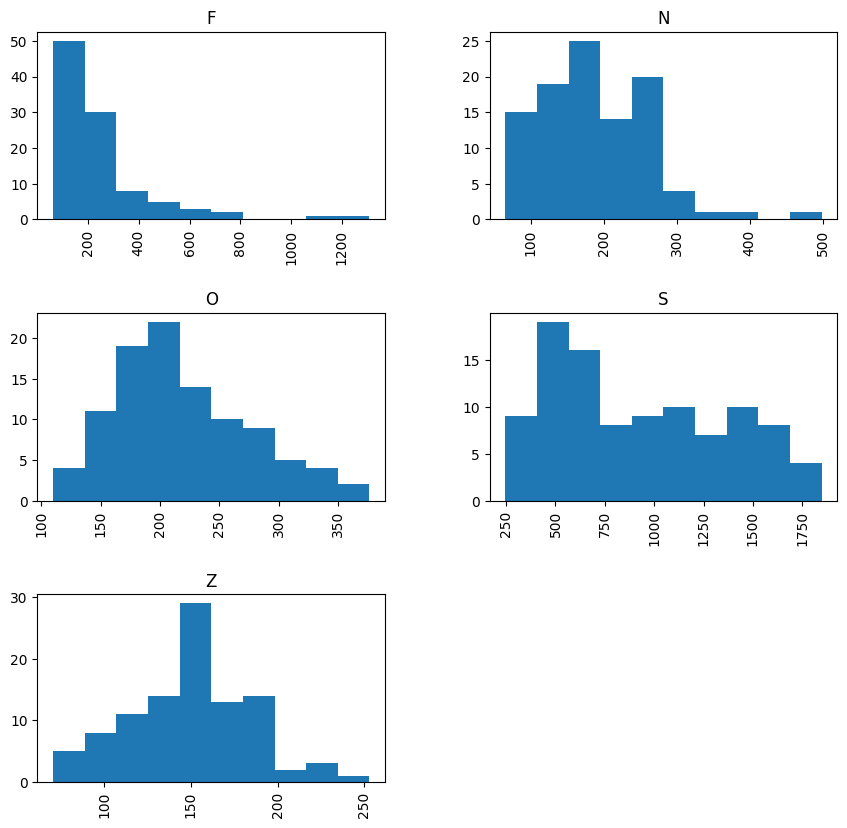

In [73]:
fset_cesium['amplitude'].hist(by=fset_cesium['classes'])

#### ... and like this we can ctn to do some feature selection
#### and visualization Aileen also emphasizes on the added benefit
#### of hand coding up some of these features yourself on runtime
##### compl for eg


### So we can begin our ML model training 👾👾

In [74]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [75]:


# Encode the target variable in the fset_cesium DataFrame
label_encoder = LabelEncoder()
fset_cesium['classes'] = label_encoder.fit_transform(fset_cesium['classes'])

# Separate features and target
features = fset_cesium.iloc[:, 1:6].values  # Assuming columns 1 to 5 are the features
target = fset_cesium['classes'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=21)

# Train the model
clf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=21)
clf.fit(X_train, y_train)

# Evaluate the model
score = clf.score(X_test, y_test)
print(f"Model accuracy: {score * 100:.2f}%")


Model accuracy: 89.60%


In [76]:
score = clf.score(X_train, y_train)
print(f"Model accuracy: {score * 100:.2f}%")

Model accuracy: 88.00%


In [77]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4]), array([20, 29, 21, 25, 30]))

In [78]:
y_test.shape

(125,)

In [79]:
y_train.shape

(375,)

### So weve significanly reduced our time series datafeatures and ran our random forest model on  selected features... I suspect of overfitting tho since the model did unexpectedly well..

### Now lets try XGBoost !

In [80]:
model = xgb.XGBClassifier(n_estimators=10, max_depth=3,
                             random_state=21)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [81]:
model.score(X_test, y_test)

1.0

In [82]:
model.score(X_train, y_train)

1.0

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

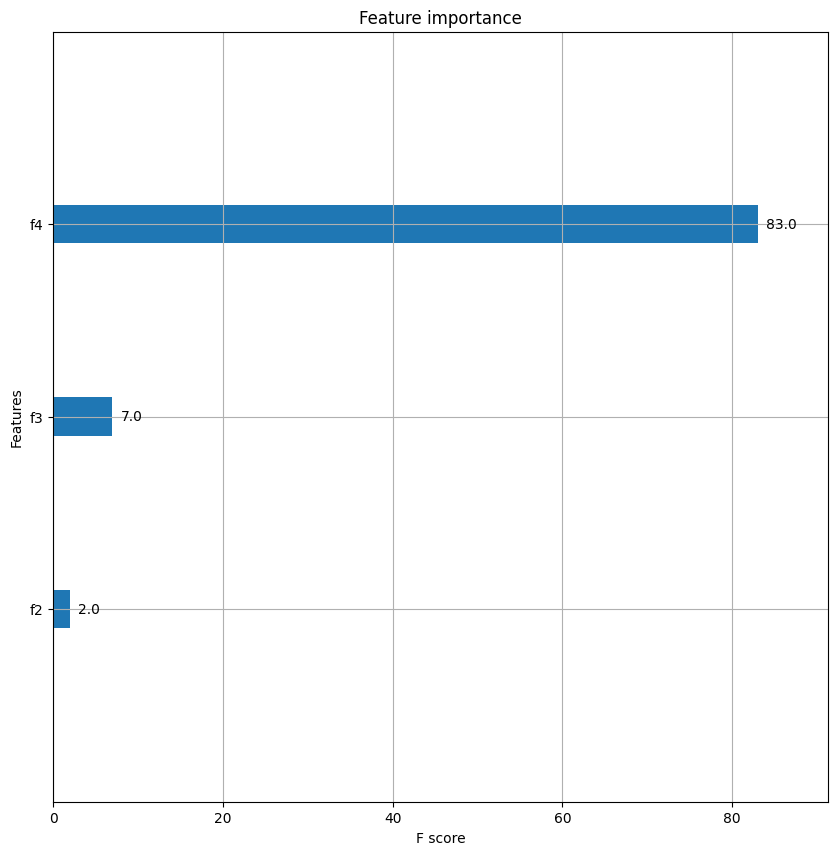

In [83]:
xgb.plot_importance(model)

#### okay now there are some clear signs of overfitting here ... 😭😭

## Time series forecasting w DT

In [84]:
ap = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=[0])

In [85]:
ap.head()

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [86]:
ap.rename(columns={'date': 'Month', 'value': '#Passengers'}, inplace=True)


In [87]:
ap.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [88]:
ap.set_index('Month', inplace=True)

In [89]:
ap.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


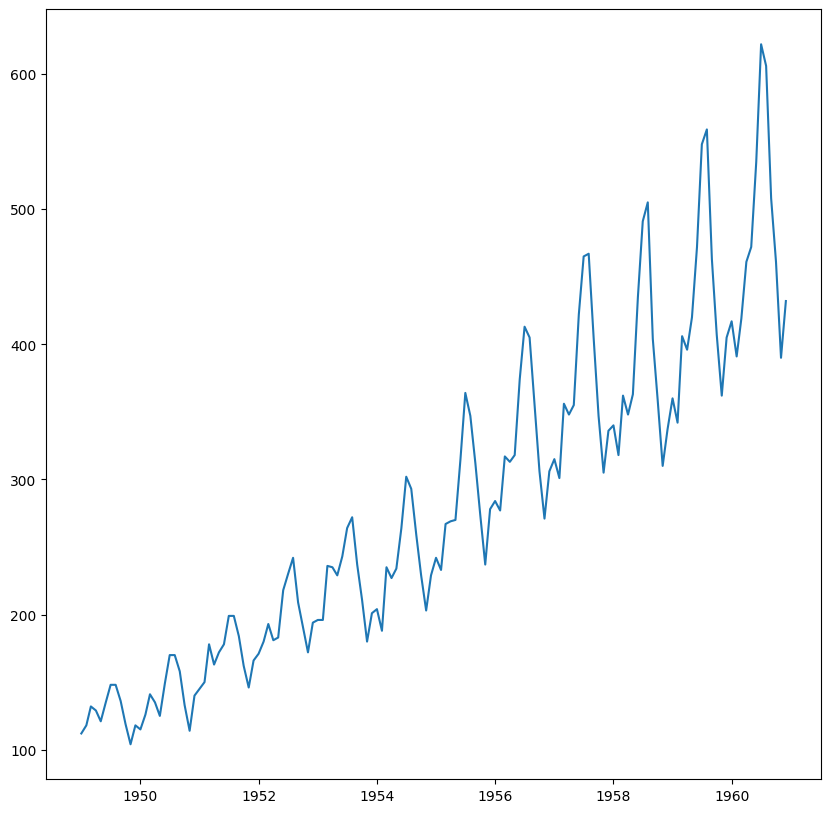

In [90]:
plt.plot(ap)

### Just as in traditional statistical modelling, its a good idea to keep general practices
### so making this stationary will prob be a good idea, so lets log transform this!

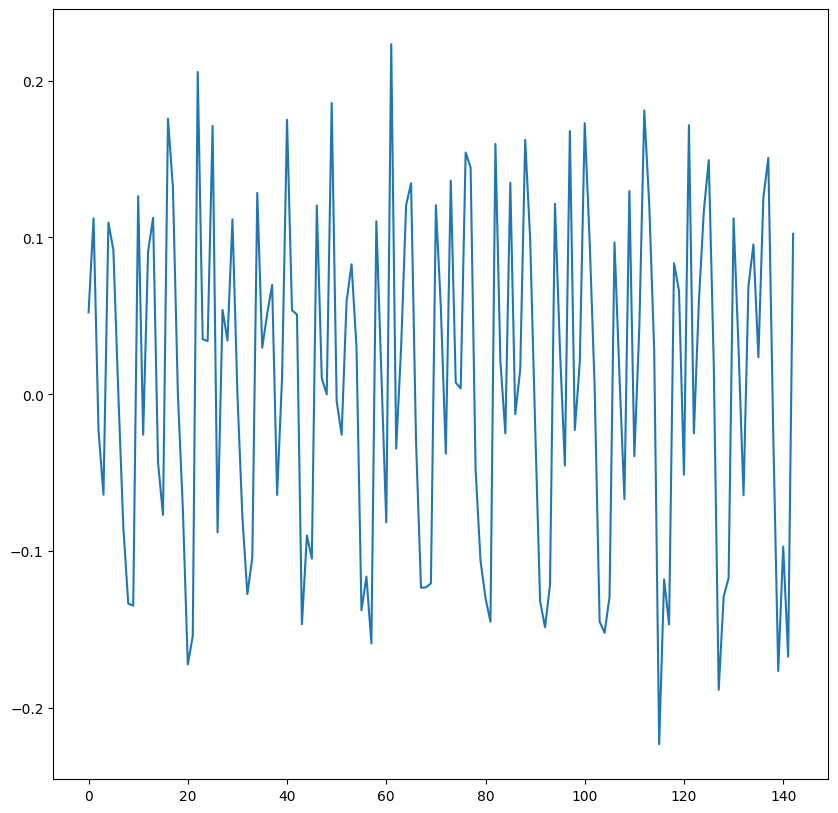

In [91]:
plt.plot(np.diff(np.log(ap.values[:, 0])))

#### The method wel use is taking one baseline time series and slicing it into samples for our ML algo

In [92]:
ts = np.diff(np.log(ap.values[:, 0]))

### So now lets look at how we can convert our time series into many samples

In [93]:
NSTEPS = 12

In [94]:
ts.shape

(143,)

In [95]:
vals = np.hstack([np.expand_dims(np.array(ts, dtype=np.float32), axis = 1) for _ in range(NSTEPS)])

In [96]:
vals.shape

(143, 12)

In [97]:
ts[0:NSTEPS]

array([ 0.05218575,  0.1121173 , -0.02298952, -0.06402186,  0.10948423,
        0.0919375 ,  0.        , -0.08455739, -0.13353139, -0.13473259,
        0.12629373, -0.0257525 ])

In [98]:
vals.shape

(143, 12)

#### In pandas 
### `lag` shifts a column down by a certain number.
### `lead` shifts a column up by a certain number.

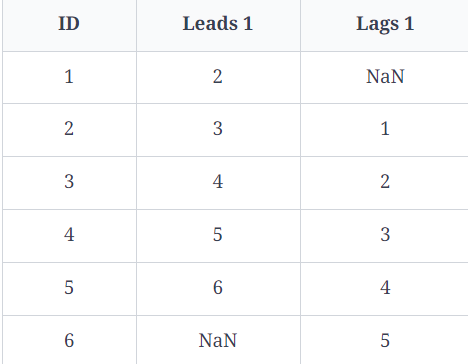

In [99]:
nrow = vals.shape[0]
for lag in range(1, vals.shape[1]):
    vals[:(nrow - lag), lag] = vals[lag:, lag]
    vals[(nrow - lag):, lag] = np.nan

In [100]:
vals

array([[ 0.05218575,  0.1121173 , -0.02298952, ..., -0.13473259,
         0.12629372, -0.0257525 ],
       [ 0.1121173 , -0.02298952, -0.06402186, ...,  0.12629372,
        -0.0257525 ,  0.09134978],
       [-0.02298952, -0.06402186,  0.10948423, ..., -0.0257525 ,
         0.09134978,  0.11247798],
       ...,
       [-0.0970834 , -0.1672513 ,  0.10227885, ...,         nan,
                nan,         nan],
       [-0.1672513 ,  0.10227885,         nan, ...,         nan,
                nan,         nan],
       [ 0.10227885,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)

In [101]:
vals = vals[:(vals.shape[0] - NSTEPS + 1), :]

In [102]:
vals.shape

(132, 12)

In [103]:
vals[-1]

array([ 0.02919916, -0.06437866,  0.06916336,  0.09552712,  0.02358094,
        0.12528776,  0.15067334, -0.02606011, -0.17639855, -0.0970834 ,
       -0.1672513 ,  0.10227885], dtype=float32)

In [104]:
ts[-NSTEPS:]

array([ 0.02919915, -0.06437866,  0.06916336,  0.09552712,  0.02358094,
        0.12528776,  0.15067335, -0.02606011, -0.17639854, -0.0970834 ,
       -0.1672513 ,  0.10227885])

In [105]:
vals.shape

(132, 12)

### Now that we have time series broken up into a set of samples, how do we featurize?

In [106]:
## converting our measures to list as per cesium dcmt sugests
measures = [vals[i][0:(NSTEPS - 1)] for i in range(vals.shape[0])]

In [107]:
times = [[j for j in range(NSTEPS - 1)] for i in range(vals.shape[0])]

In [108]:
measures[0]

array([ 0.05218575,  0.1121173 , -0.02298952, -0.06402186,  0.10948423,
        0.0919375 ,  0.        , -0.08455739, -0.13353139, -0.13473259,
        0.12629372], dtype=float32)

In [109]:
len(measures[0])

11

In [110]:
len(measures[0])

11

In [111]:
features_to_use = [
                    'amplitude',
                    'percent_beyond_1_std',
                    'skew',
                    'max_slope',
                    'percent_amplitude']
fset_ap = ft.featurize_time_series(times=times,
                                    values=measures,
                                    errors=None,
                                    features_to_use=features_to_use,
                                    scheduler = None)


In [112]:
fset_ap.columns = fset_ap.columns.droplevel(-1)

In [113]:
fset_ap.head()

feature,amplitude,percent_beyond_1_std,skew,max_slope,percent_amplitude
0,0.130513,0.454545,-0.155365,0.261026,0.132121
1,0.130513,0.545455,0.051772,0.261026,0.128461
2,0.130513,0.545455,0.037850,0.261026,0.128461
3,0.130513,0.454545,-0.192651,0.261026,0.132121
4,0.130513,0.454545,-0.233966,0.261026,0.132121


(array([15.,  7.,  5., 23., 26., 17.,  6.,  6., 16., 11.]),
 array([0.12786029, 0.1352786 , 0.14269691, 0.15011522, 0.15753352,
        0.16495183, 0.17237014, 0.17978845, 0.18720675, 0.19462506,
        0.20204337]),
 <BarContainer object of 10 artists>)

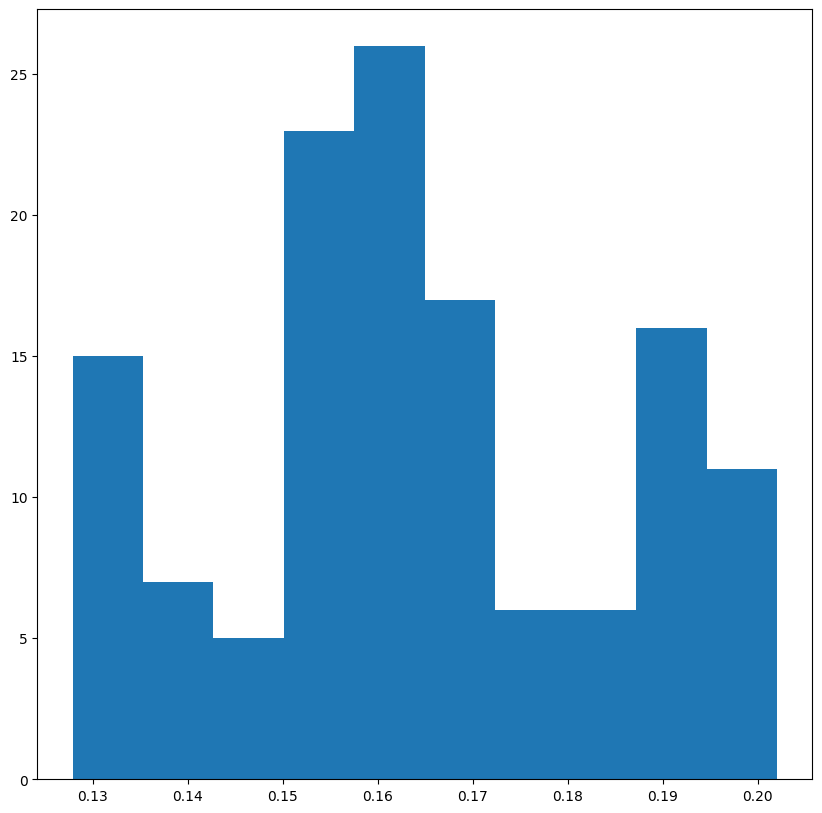

In [114]:
plt.hist(fset_ap.amplitude)

(array([16., 40., 35.,  4., 15.,  9.,  1.,  9.,  2.,  1.]),
 array([0.12414427, 0.14138614, 0.15862801, 0.17586988, 0.19311176,
        0.21035363, 0.2275955 , 0.24483737, 0.26207924, 0.27932111,
        0.29656298]),
 <BarContainer object of 10 artists>)

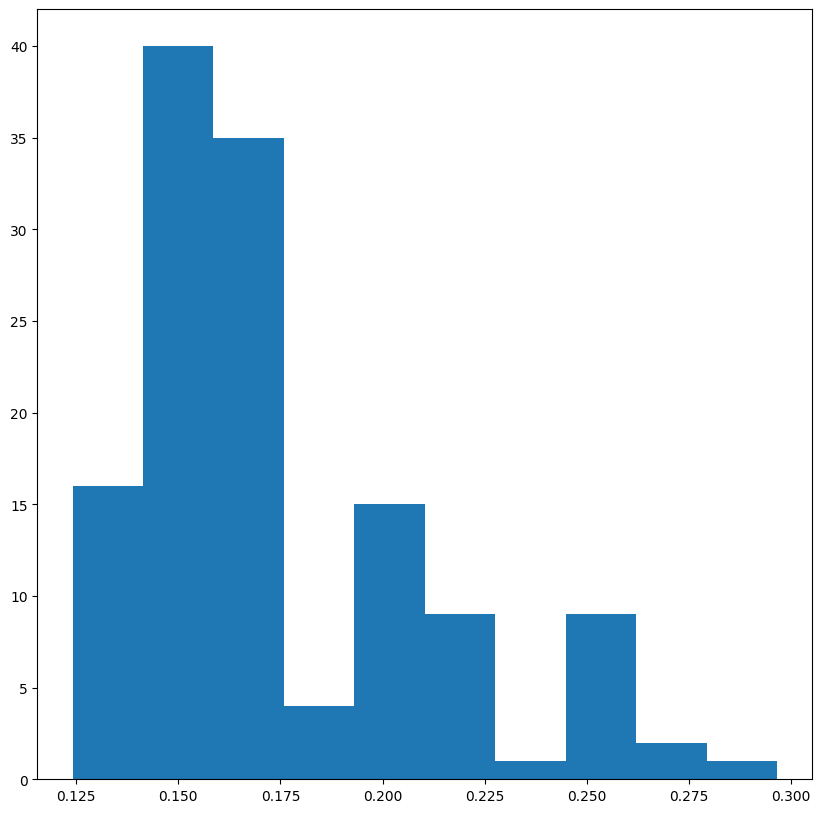

In [115]:
plt.hist(fset_ap.percent_amplitude)

(array([ 9., 11.,  8., 23., 26., 25., 18.,  9.,  2.,  1.]),
 array([-0.56547007, -0.45117751, -0.33688495, -0.22259239, -0.10829984,
         0.00599272,  0.12028528,  0.23457784,  0.3488704 ,  0.46316296,
         0.57745551]),
 <BarContainer object of 10 artists>)

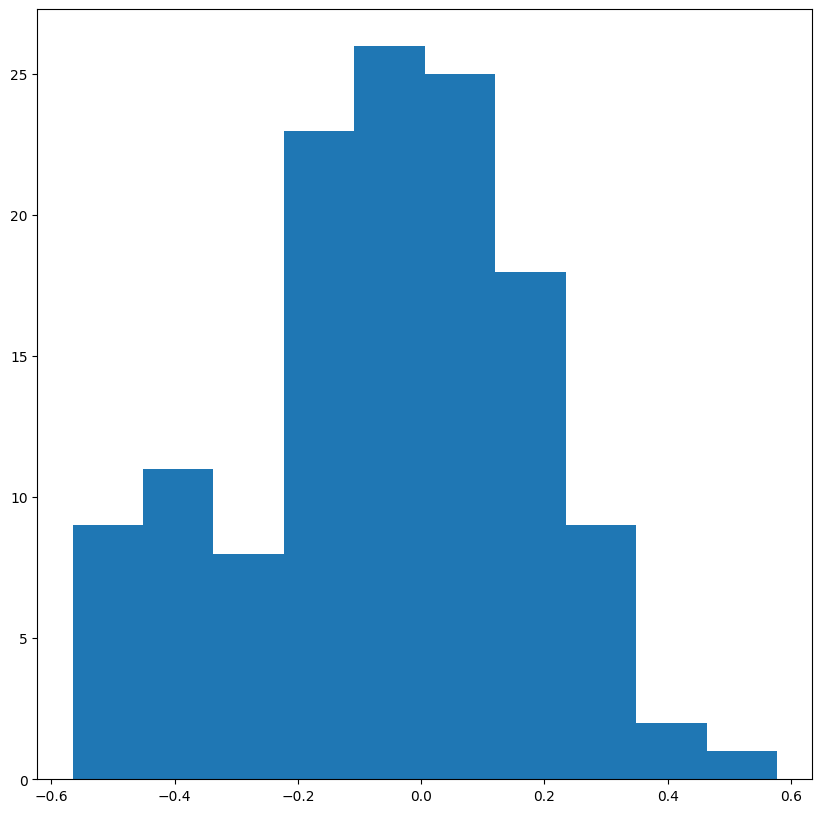

In [116]:
plt.hist(fset_ap['skew'])

### Now lets fit an XGBoost Regressor instead of a Classificator (lol) 
### Lets use the first 100 ts as training data

In [117]:
outcomes = vals[:, -1]

In [118]:
X_train, y_train = fset_ap.iloc[:100, :], outcomes[:100]
X_test, y_test = fset_ap.iloc[100:, :], outcomes[100:]

In [119]:
X_train.shape

(100, 5)

In [120]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2, random_state=21)

In [121]:
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric='rmse', eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.11648
[1]	validation_0-rmse:0.11906
[2]	validation_0-rmse:0.12401
[3]	validation_0-rmse:0.12917
[4]	validation_0-rmse:0.13594
[5]	validation_0-rmse:0.13500
[6]	validation_0-rmse:0.13542
[7]	validation_0-rmse:0.14053
[8]	validation_0-rmse:0.13899
[9]	validation_0-rmse:0.13818
[10]	validation_0-rmse:0.13772
[11]	validation_0-rmse:0.14335
[12]	validation_0-rmse:0.14281
[13]	validation_0-rmse:0.14573
[14]	validation_0-rmse:0.14678
[15]	validation_0-rmse:0.14869
[16]	validation_0-rmse:0.14782
[17]	validation_0-rmse:0.14889
[18]	validation_0-rmse:0.14710
[19]	validation_0-rmse:0.14991


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=21, ...)

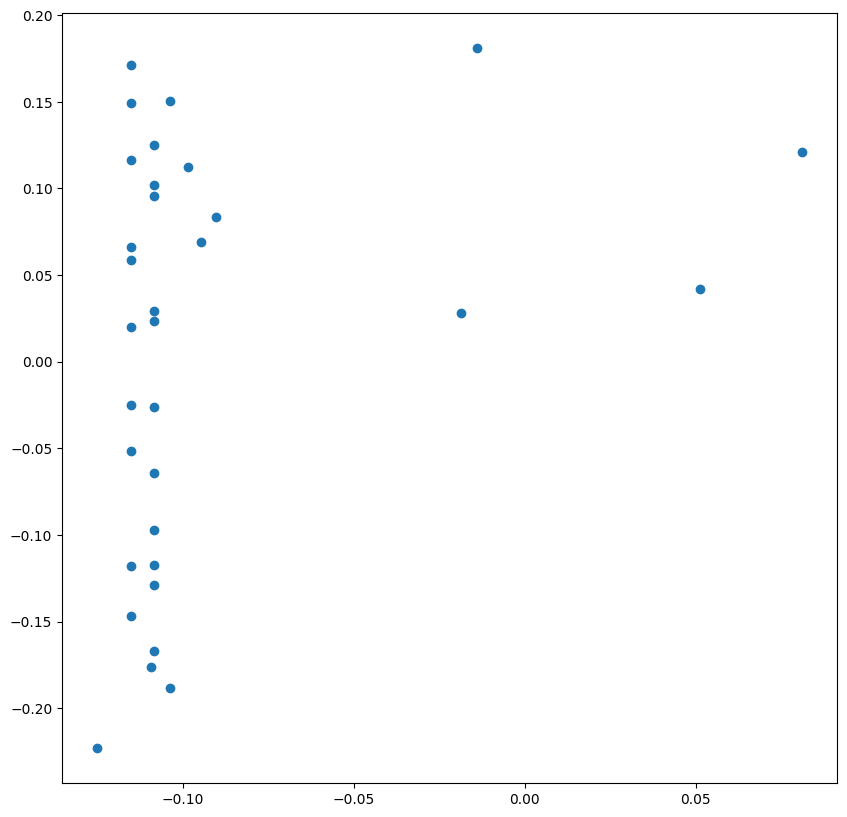

In [122]:
plt.scatter(model.predict(X_test), y_test)

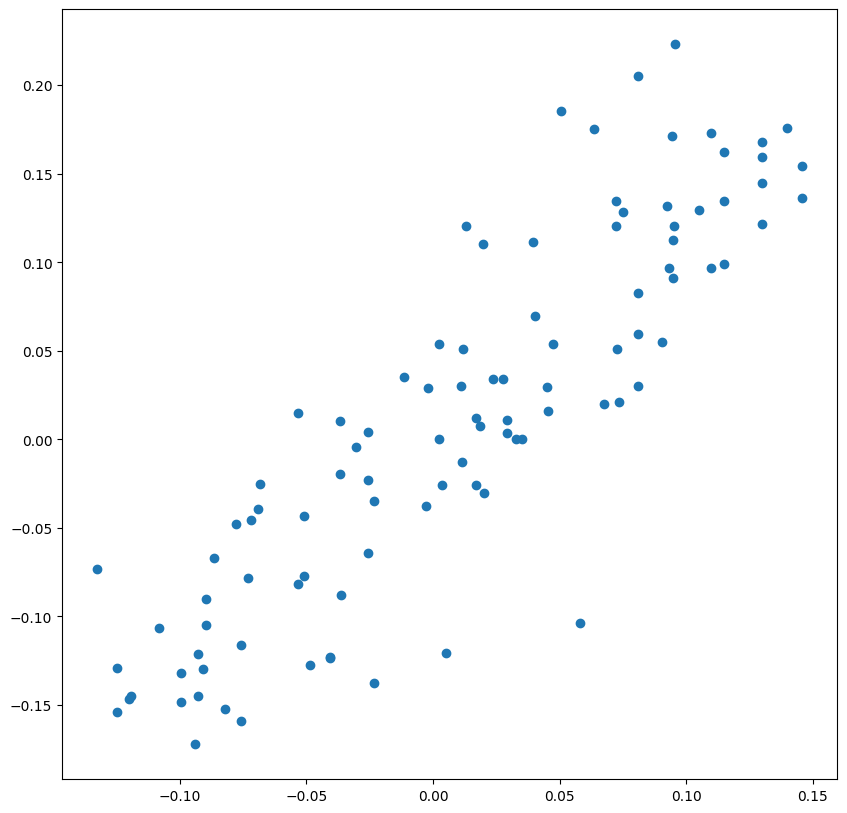

In [123]:
plt.scatter(model.predict(X_train), y_train)

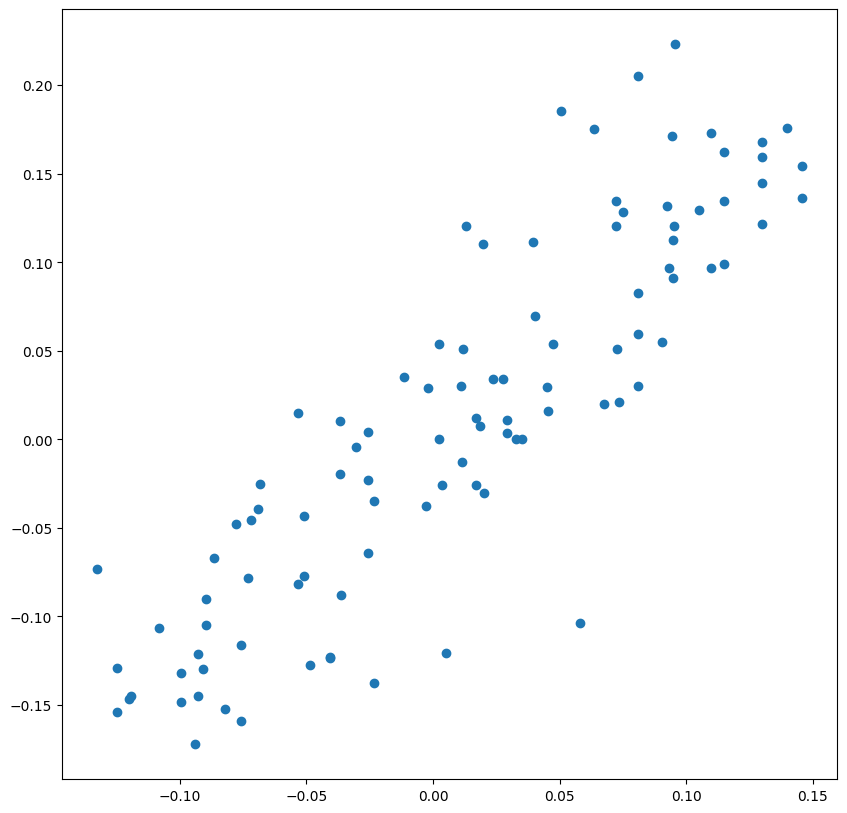

In [124]:
plt.scatter(model.predict(X_train), y_train)

In [125]:
pearsonr(model.predict(X_train), y_train)

PearsonRResult(statistic=0.8742441268730647, pvalue=1.6129630456602258e-32)

In [126]:
pearsonr(model.predict(X_test), y_test)

PearsonRResult(statistic=0.29185585544126086, pvalue=0.10505829754004031)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

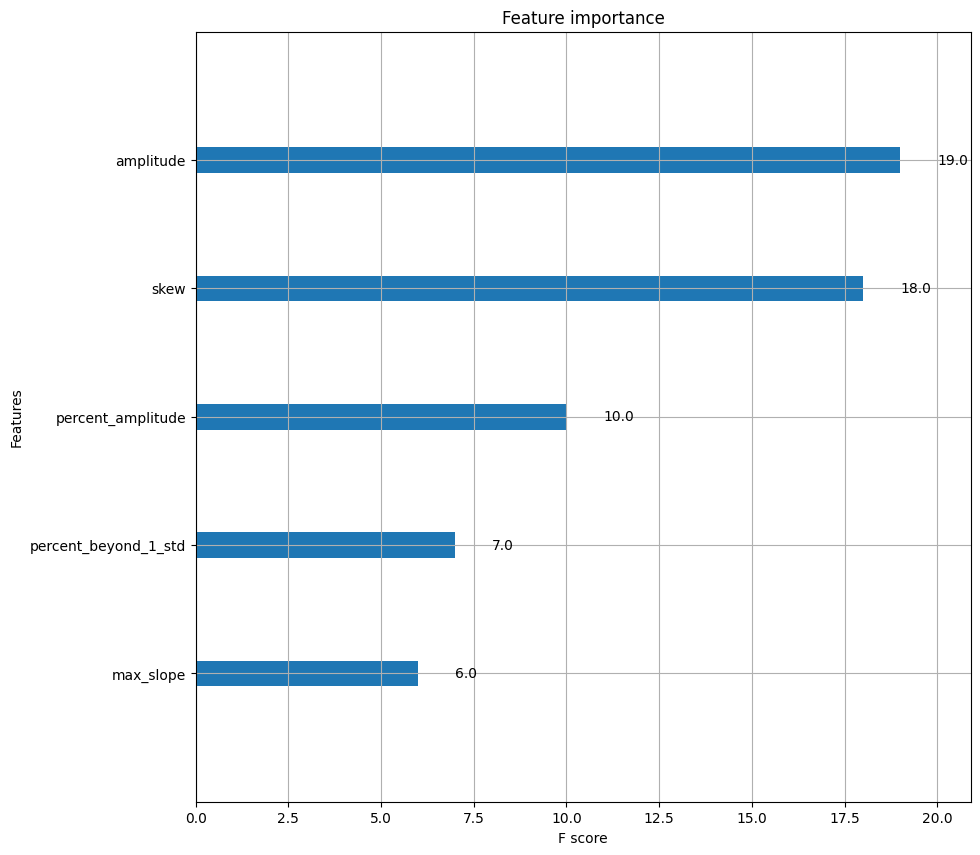

In [127]:
xgb.plot_importance(model)

#### Okay so our model didnt do too bad but we can improve upon it !

In [128]:
### lets revisit the featureset
fset_ap.head()

feature,amplitude,percent_beyond_1_std,skew,max_slope,percent_amplitude
0,0.130513,0.454545,-0.155365,0.261026,0.132121
1,0.130513,0.545455,0.051772,0.261026,0.128461
2,0.130513,0.545455,0.037850,0.261026,0.128461
3,0.130513,0.454545,-0.192651,0.261026,0.132121
4,0.130513,0.454545,-0.233966,0.261026,0.132121


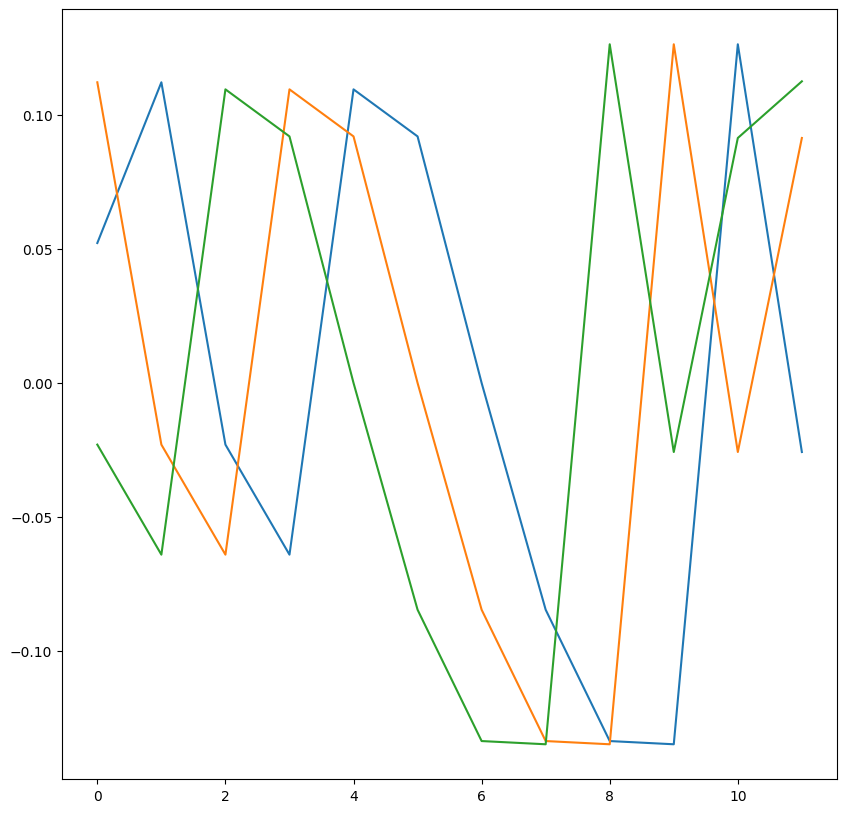

In [129]:
plt.plot(vals[0])
plt.plot(vals[1])
plt.plot(vals[2])


#### We can see that we have a lot of variation within our x and y axis so lets generate features
#### that encode positional info

In [130]:
vals.shape

(132, 12)

In [132]:
feats = np.zeros( (vals.shape[0], 6), dtype=np.float32)
for i in range(vals.shape[0]):
    feats[i, 0] = np.where(vals[i] == np.max(vals[i]))[0][0] ## at which time stamp is the max
    feats[i, 1] = np.where(vals[i] == np.max(vals[i]))[0][0] ## at which time stamp is the min
    feats[i, 2] = feats[i, 0] - feats[i, 1] ## distance b/w min and max 
    feats[i, 3] = np.max(vals[i][-3:])
    feats[i, 4] = vals[i][-1] - vals[i][-2]
    feats[i, 5] = vals[i][-1] - vals[i][-3]


In [133]:
feats[0:3]

array([[10.        , 10.        ,  0.        ,  0.12629372, -0.15204622,
         0.10898009],
       [ 9.        ,  9.        ,  0.        ,  0.12629372,  0.11710228,
        -0.03494394],
       [ 8.        ,  8.        ,  0.        ,  0.11247798,  0.0211282 ,
         0.13823047]], dtype=float32)

In [134]:
pd.DataFrame(feats[0:3])

,0,1,2,3,4,5
0,10.0,10.0,0.0,0.126294,-0.152046,0.108980
1,9.0,9.0,0.0,0.126294,0.117102,-0.034944
2,8.0,8.0,0.0,0.112478,0.021128,0.138230


### Okay so we went from having exact same values to somewhat a variation in values so that is atleast an improvement!

In [135]:
pd.DataFrame(feats[0:3])

,0,1,2,3,4,5
0,10.0,10.0,0.0,0.126294,-0.152046,0.108980
1,9.0,9.0,0.0,0.126294,0.117102,-0.034944
2,8.0,8.0,0.0,0.112478,0.021128,0.138230


In [136]:
X_train, y_train = feats[:100, :], outcomes[:100]
X_test, y_test = feats[100:, :], outcomes[100:]

In [137]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                            random_state=21)
eval_set  = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric='rmse', eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.10240
[1]	validation_0-rmse:0.09587
[2]	validation_0-rmse:0.08990
[3]	validation_0-rmse:0.08540
[4]	validation_0-rmse:0.08037
[5]	validation_0-rmse:0.07273
[6]	validation_0-rmse:0.06910
[7]	validation_0-rmse:0.06729
[8]	validation_0-rmse:0.06523
[9]	validation_0-rmse:0.06291
[10]	validation_0-rmse:0.06074
[11]	validation_0-rmse:0.05939
[12]	validation_0-rmse:0.05844
[13]	validation_0-rmse:0.05777
[14]	validation_0-rmse:0.05639
[15]	validation_0-rmse:0.05573
[16]	validation_0-rmse:0.05553
[17]	validation_0-rmse:0.05429
[18]	validation_0-rmse:0.05417
[19]	validation_0-rmse:0.05320


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=21, ...)

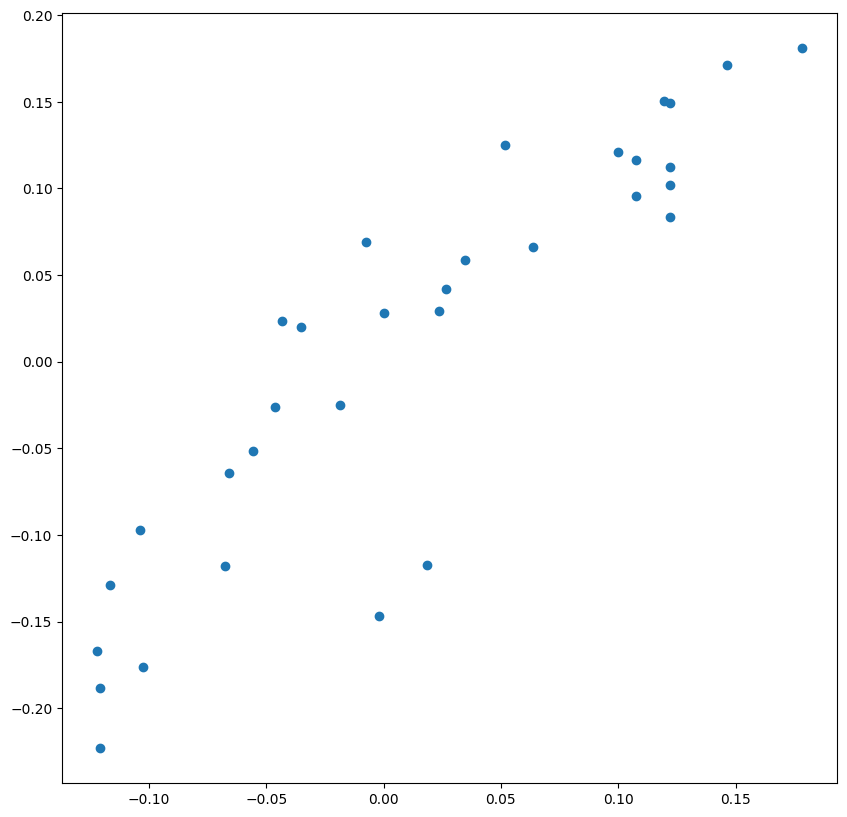

In [138]:
plt.scatter(model.predict(X_test), y_test)

### okay so RMSE wasnt really telling the full story since as we can see our scatter plot is significantly better compared to the prev one

In [140]:
print(pearsonr(model.predict(X_test), y_test))
print(spearmanr(model.predict(X_test), y_test))

PearsonRResult(statistic=0.9001907294494786, pvalue=2.3540926404844693e-12)
SignificanceResult(statistic=0.9161930599804791, pvalue=1.909859439883152e-13)


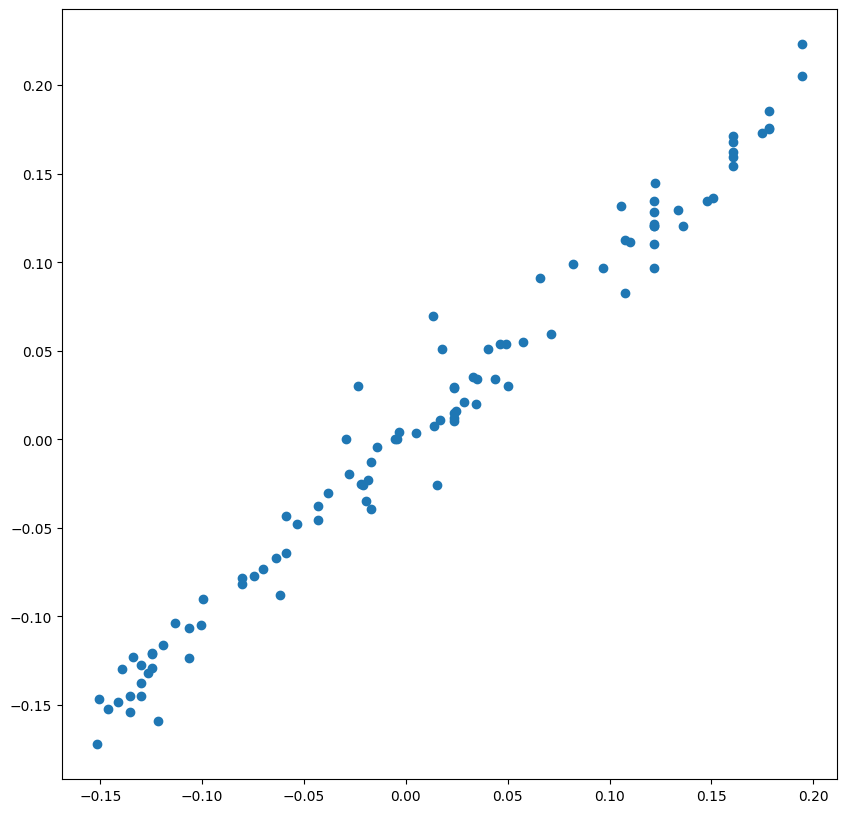

In [141]:
plt.scatter(model.predict(X_train), y_train)

In [142]:
print(pearsonr(model.predict(X_train), y_train))
print(spearmanr(model.predict(X_train), y_train))

PearsonRResult(statistic=0.989589586425728, pvalue=2.5410596074179185e-84)
SignificanceResult(statistic=0.9851173037284471, pvalue=9.215544001207016e-77)


## Clustering time series for Classification

In [145]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize']= [15, 10]

from math import sqrt

from datetime import datetime
import pandas as pd 
import numpy as np 
import pdb

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics.cluster import homogeneity_score, completeness_score
from sklearn.metrics.cluster import homogeneity_score

from dtaidistance import dtw
from collections import Counter
from scipy.stats import pearsonr


In [144]:
pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 35.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [146]:
words = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/50words_TEST.csv')

In [162]:
words_shifted = words_reset.shift(1)

In [163]:
words_shifted.iloc[0] = words.columns

ValueError: Must have equal len keys and value when setting with an iterable

In [154]:
words.rename(columns={'0': 'word'}, inplace=True)


In [152]:
words.rename(columns = {4:'word'}, inplace=True)

In [155]:
words.head()

,4,-0.89094,-0.86099,-0.82438,-0.78214,-0.73573,-0.68691,-0.63754,-0.58937,-0.54342,...,-0.86309,-0.86791,-0.87271,-0.87846,-0.88592,-0.89619,-0.90783,-0.91942,-0.93018,-0.93939
0,12,-0.78346,-0.68562,-0.58409,-0.47946,-0.37398,-0.27008,-0.17225,-0.087463,-0.019191,...,-0.88318,-0.89189,-0.90290,-0.91427,-0.92668,-0.93966,-0.95244,-0.96623,-0.9805,-0.99178
1,13,-1.32560,-1.28430,-1.21970,-1.15670,-1.09980,-1.04960,-1.01550,-0.996720,-0.985040,...,-0.83499,-0.86204,-0.88559,-0.90454,-0.93353,-0.99135,-1.06910,-1.13680,-1.1980,-1.27000
2,23,-1.09370,-1.04200,-0.99840,-0.95997,-0.93997,-0.93764,-0.92649,-0.857090,-0.693320,...,-0.72810,-0.74512,-0.76376,-0.78068,-0.80593,-0.84350,-0.89531,-0.96052,-1.0509,-1.12830
3,4,-0.90138,-0.85228,-0.80196,-0.74932,-0.69298,-0.63316,-0.57038,-0.506920,-0.446040,...,-0.95452,-0.97322,-0.98984,-1.00520,-1.01880,-1.02960,-1.03700,-1.04110,-1.0418,-1.04030
4,13,-1.24470,-1.22000,-1.16940,-1.09130,-0.98968,-0.86828,-0.73462,-0.595370,-0.457100,...,-0.59899,-0.69078,-0.78410,-0.87322,-0.95100,-1.01550,-1.07050,-1.12200,-1.1728,-1.21670


In [ ]:
words = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/50words_TEST.csv')